# 物理神经网络(PINN)

传统深度学习仅依赖数据驱动，缺乏对物理规律的先验认知，可能导致预测结果不符合实际物理逻辑（如能量不守恒、违反质量守恒）；而传统数值方法依赖网格离散，在高维问题（如10维以上）中面临“维数灾难”。

PINN 的本质是**将物理定律作为“软约束”或“硬约束”融入神经网络训练**，实现“数据+物理”的双驱动建模：
1. 神经网络作为**参数化的解函数**：用神经网络逼近 PDE 的未知解（例如用 $u_\theta(x,t)$ 逼近真实解 $u(x,t)$，其中 $\theta$ 是网络参数）。
2. 物理约束嵌入损失函数：通过自动微分计算神经网络的各阶导数，代入 PDE 得到“残差”，将残差最小化作为损失函数的一部分，强制网络输出满足物理定律。
3. 观测数据拟合：若存在少量观测数据（如实验测量值、边界/初始条件），同时最小化网络预测值与观测值的误差，实现数据与物理的协同优化。



PINN 的损失函数 $\mathcal{L}$ 是多部分加权和，核心包括 “物理残差损失” 和 “数据拟合损失”：
$$\mathcal{L} = \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{IC}} + \mathcal{L}_{\text{BC}} + \mathcal{L}_{\text{data}} \tag{5.1}$$
- PDE 残差损失 $\mathcal{L}_{\text{PDE}}$：在随机采样的时空点上，最小化 $|u_t - u_{xx}|$：
  $$\mathcal{L}_{\text{PDE}} = \frac{1}{N_{\text{PDE}}} \sum_{i=1}^{N_{\text{PDE}}} |\frac{\partial u(x_i^p, t_i^p)}{\partial t} - \frac{\partial^2 u(x_i^p, t_i^p)}{\partial x^2}|^2 \tag{5.2}$$
- 初始条件损失 $\mathcal{L}_{\text{IC}}$：在 $t=0$ 的采样点上，最小化 $|u(x,0) - \sin(\pi x)|$：
  $$\mathcal{L}_{\text{IC}} = \frac{1}{N_{\text{IC}}} \sum_{i=1}^{N_{\text{IC}}} |u(x_i^c, 0) - \sin(\pi x_i^c)|^2\tag{5.3}$$
- 边界条件损失 $\mathcal{L}_{\text{BC}}$：在 $x=0$ 或 $x=1$ 的采样点上，最小化 $|u(0,t)| + |u(1,t)|$：
  $$\mathcal{L}_{\text{BC}} = \frac{1}{N_{\text{BC}}} \sum_{i=1}^{N_{\text{BC}}} \left( |u(0, t_i^b)|^2 + |u(1, t_i^b)|^2 \right) \tag{5.4}$$
- 观测数据损失 $\mathcal{L}_{\text{data}}$：若存在少量观测数据 $\{(x_i,t_i, u_i)\}_{i=1}^{N_{\text{data}}}$（$u_i$ 为真实测量值），最小化$\left| u_\theta(x_i,t_i) - u_i \right|$：
  $$ \mathcal{L}_{\text{data}} = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \left| u_\theta(x_i,t_i) - u_i \right|^2 \tag{5.5}$$

## 编程作业：用于热方程的物理信息神经网络（PINN）

### 一维热方程（基准问题）：
$$u_t = u_{xx}, \quad x \in (0, 1),\ t \in (0, 1), \quad u(x, 0) = \sin(\pi x), \quad u(0, t) = u(1, t) = 0.$$

**精确解：**
$$u_{\text{exact}}(x, t) = e^{-\pi^2 t} \sin(\pi x).$$

**你在一维问题中的任务：**
- 实现一个物理信息神经网络 $u_\theta(x, t)$，并利用 PDE 损失、初始条件损失和边界条件损失对其进行训练。
- 记录并绘制**训练损失随迭代次数的变化曲线**，对比三种优化器：SGD、Adam、LBFGS。
- 计算数值误差 $E = \|u_\theta - u_{\text{exact}}\|_{L^2}$，并在测试网格上绘制**逐点绝对误差** $|u_\theta(x, t) - u_{\text{exact}}(x, t)|$。


### 高维扩展（五维热方程）：
考虑 $d$ 维热方程
$$u_t = \Delta u, \quad x \in (0, 1)^d,\ t \in (0, 1)$$
其可分离精确解为
$$u_{\text{exact}}(x, t) = e^{-\lambda t} \prod_{k=1}^d \sin(\pi x_k), \quad \lambda = d\pi^2.$$

**你在 $d=5$ 时的任务：**
- 将你的物理信息神经网络扩展为 $u_\theta(x_1, \dots, x_5, t)$。
- 使用 Adam 和 LBFGS 进行训练；对比收敛曲线。
- 在随机测试集上（蒙特卡洛方法）评估 $L^2$ 误差。


使用SGD训练
轮数 1000 | 总损失: 0.056440 | PDE损失: 0.014152 | 初始条件损失: 0.028316 | 边界条件损失: 0.013972
轮数 2000 | 总损失: 0.004723 | PDE损失: 0.002781 | 初始条件损失: 0.000992 | 边界条件损失: 0.000950
轮数 3000 | 总损失: 0.001237 | PDE损失: 0.000905 | 初始条件损失: 0.000097 | 边界条件损失: 0.000235
轮数 4000 | 总损失: 0.000753 | PDE损失: 0.000584 | 初始条件损失: 0.000045 | 边界条件损失: 0.000124
轮数 5000 | 总损失: 0.000347 | PDE损失: 0.000234 | 初始条件损失: 0.000013 | 边界条件损失: 0.000100
轮数 6000 | 总损失: 0.000275 | PDE损失: 0.000172 | 初始条件损失: 0.000013 | 边界条件损失: 0.000090
轮数 7000 | 总损失: 0.000201 | PDE损失: 0.000116 | 初始条件损失: 0.000013 | 边界条件损失: 0.000073
轮数 8000 | 总损失: 0.000166 | PDE损失: 0.000090 | 初始条件损失: 0.000012 | 边界条件损失: 0.000064
轮数 9000 | 总损失: 0.000142 | PDE损失: 0.000073 | 初始条件损失: 0.000012 | 边界条件损失: 0.000057
轮数 10000 | 总损失: 0.000127 | PDE损失: 0.000065 | 初始条件损失: 0.000013 | 边界条件损失: 0.000049
SGD训练时间: 74.86 秒(1.25 分钟)
SGD L2 误差: 0.003678

使用Adam训练
轮数 1000 | 总损失: 0.001342 | PDE损失: 0.000967 | 初始条件损失: 0.000090 | 边界条件损失: 0.000285
轮数 2000 | 总损失: 0.000294 | PDE损失: 0.000217 | 初始条件损失: 0.

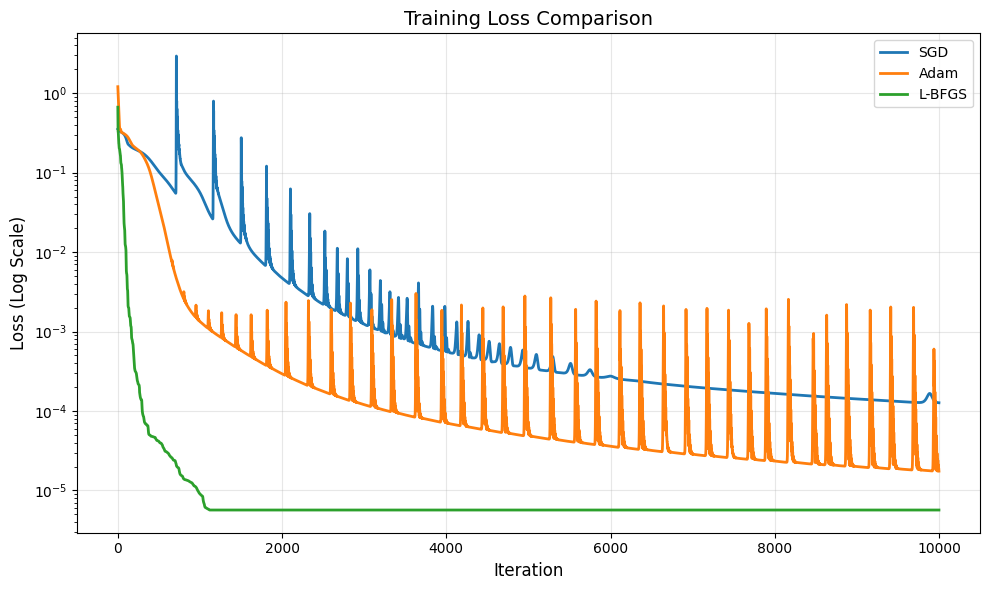

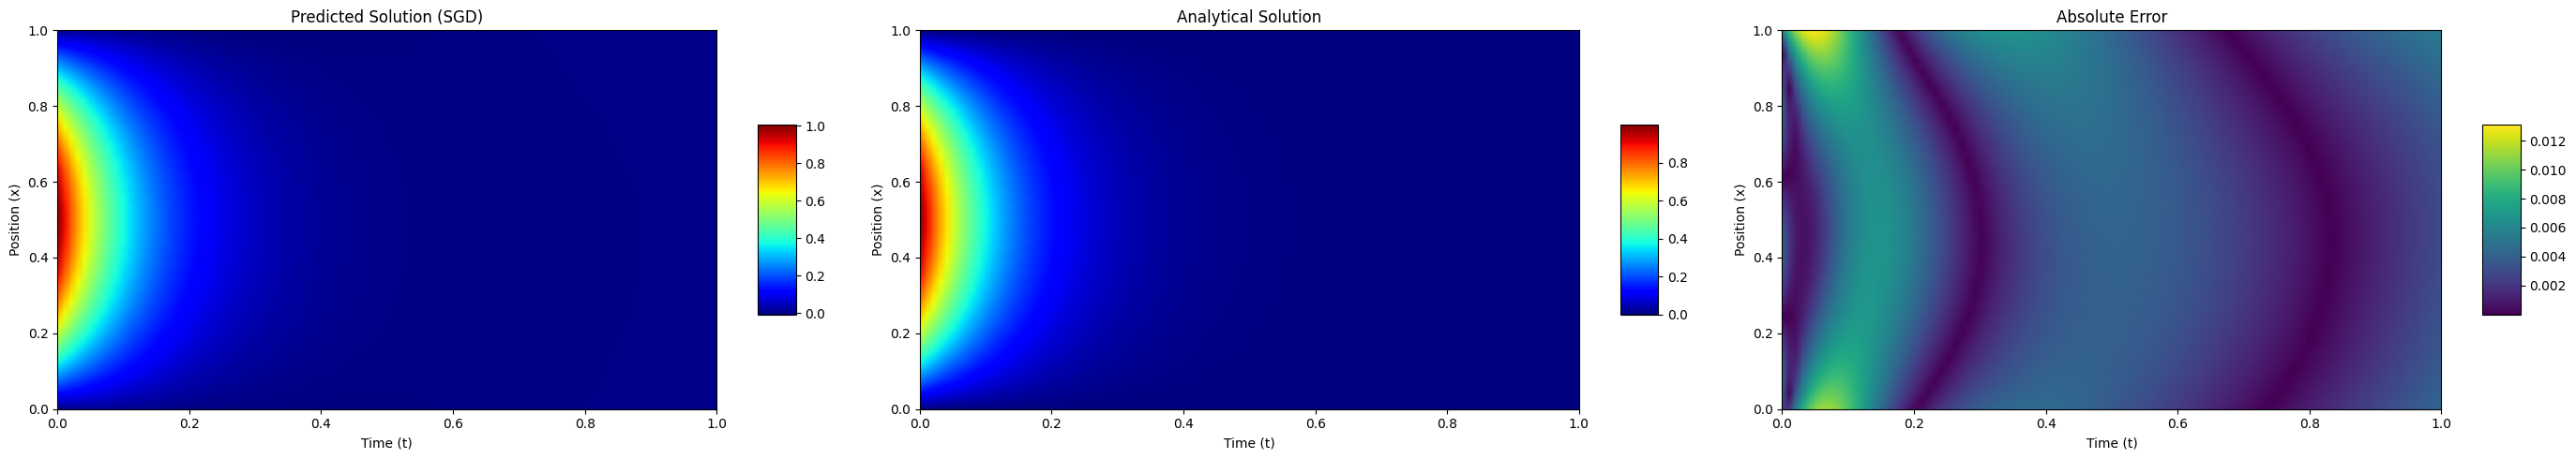

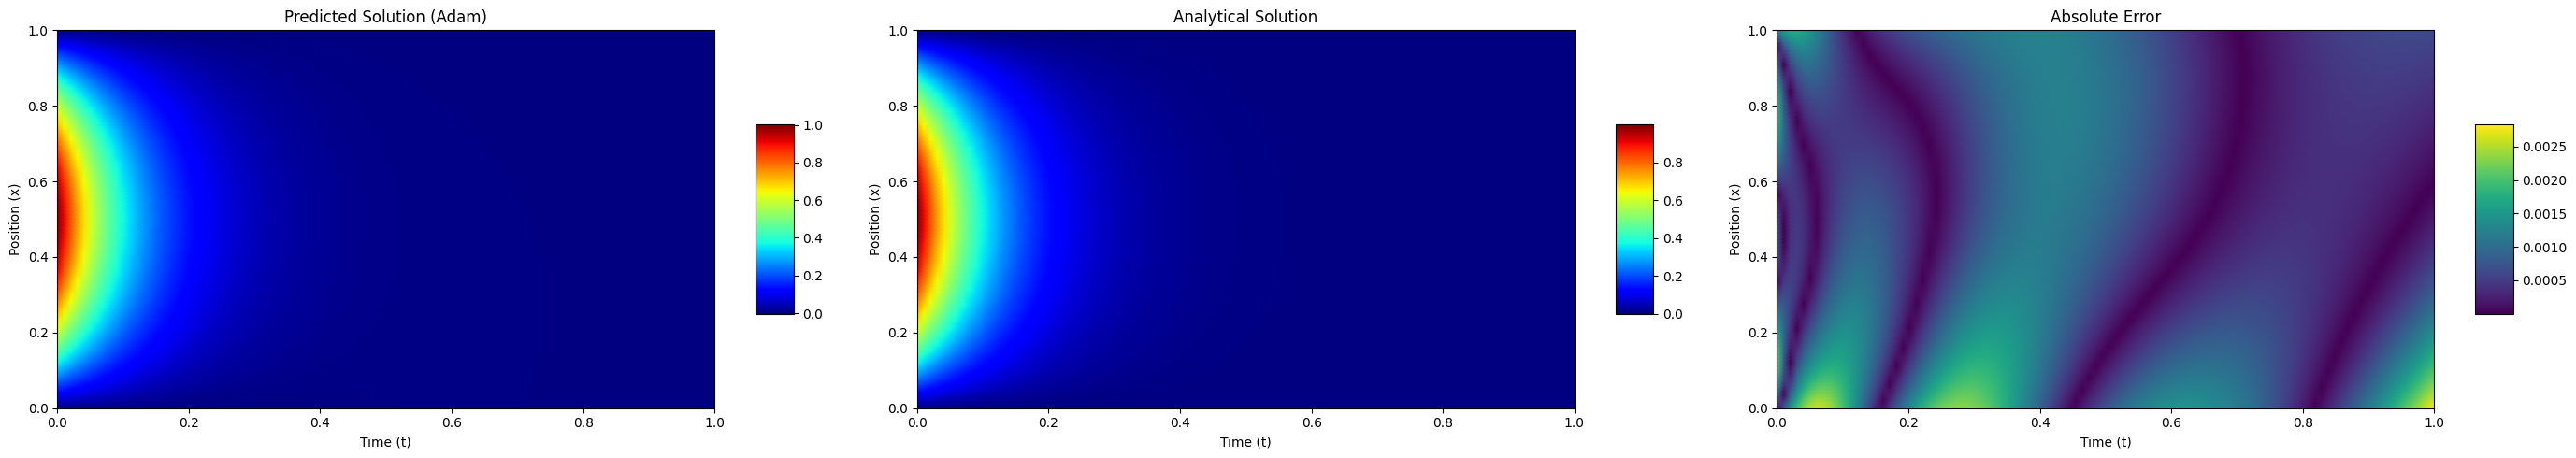

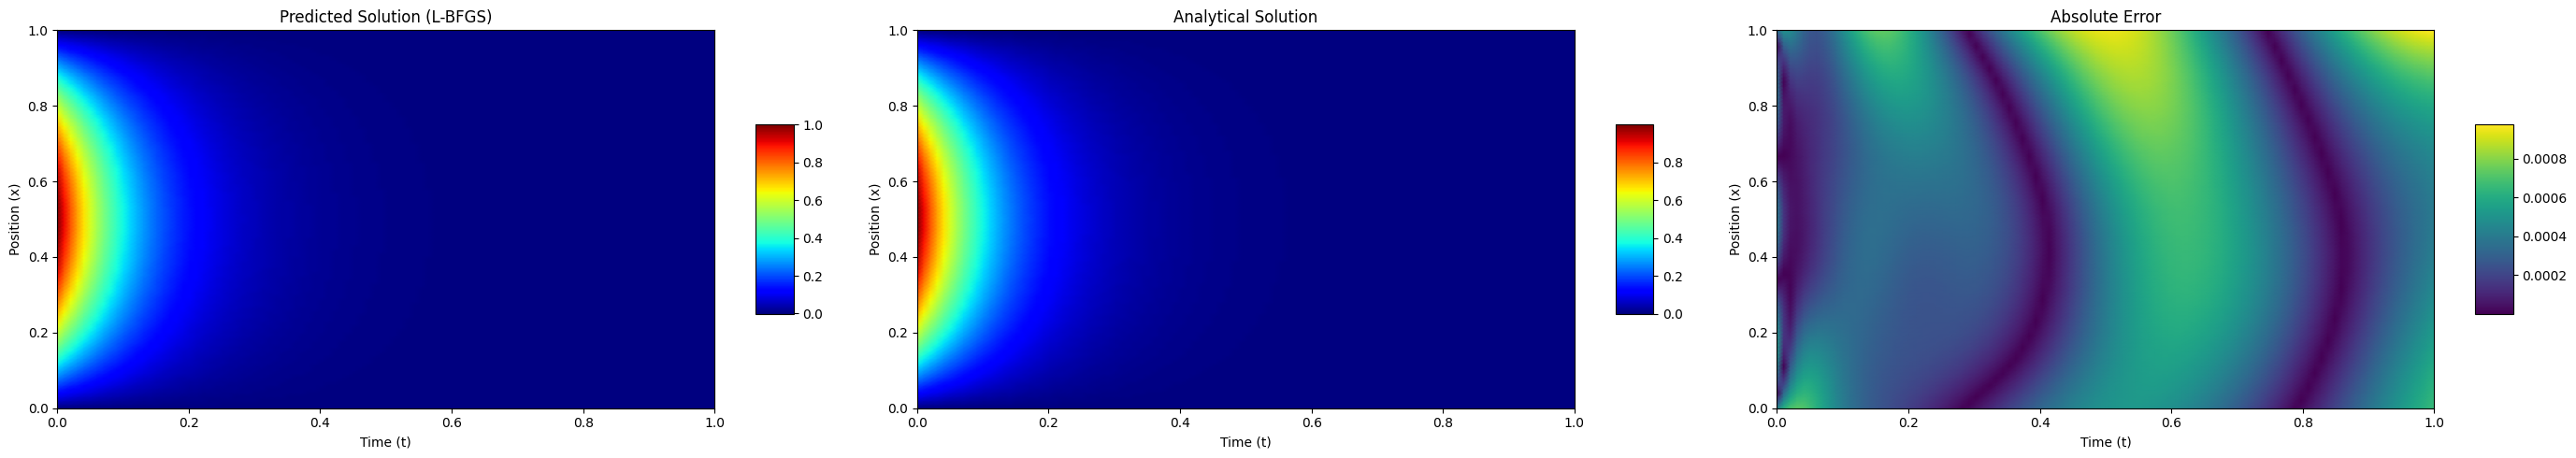


训练时间对比
SGD        | 训练时间: 74.86 秒 (1.25 分钟)
Adam       | 训练时间: 75.73 秒 (1.26 分钟)
L-BFGS     | 训练时间: 496.90 秒 (8.28 分钟)

最终L2误差对比
SGD        | L2 误差: 0.003678
Adam       | L2 误差: 0.000801
L-BFGS     | L2 误差: 0.000415


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm 
import matplotlib.pyplot as plt
import time 

# 设置随机种子以保证结果可复现
torch.manual_seed(1224)
np.random.seed(1224)

# 1. 定义PINN模型
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(PINN, self).__init__()
        # 输入层
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        # 隐藏层，层数为 n_layers - 1
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        # 输出层
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)
    
    # 前向传播
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """前向传播：输入 x 和 t，输出预测值 u"""
        input_tensor = torch.cat([x, t], dim=1) # 在列方向拼接 x 和 t
        for layer in self.layers:
            input_tensor = layer(input_tensor)
        return input_tensor

    # 计算偏导数的函数
    def compute_gradients(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """计算偏导数 u_t（对 t 的一阶偏导）和 u_xx（对 x 的二阶偏导）"""
        u = self.forward(x, t) # 预测值
        # 计算 u_t：对 t 的一阶偏导
        u_t = torch.autograd.grad(
            outputs=u,
            inputs=t,
            grad_outputs=torch.ones_like(u), # 与 u 形状相同的梯度输出张量
            create_graph=True,  # 保留计算图，用于二阶导数计算
            retain_graph=True,  # 保留计算图，避免后续计算报错
            only_inputs=True    # 仅计算输入的梯度
        )[0]
        # 计算 u_x：对 x 的一阶偏导
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u), # 与 u 形状相同的梯度输出张量
            create_graph=True,  # 保留计算图，用于二阶导数计算
            retain_graph=True,  # 保留计算图，避免后续计算报错
            only_inputs=True    # 仅计算输入的梯度
        )[0]
        # 计算 u_xx：对 x 的二阶偏导
        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=x,
            grad_outputs=torch.ones_like(u_x), # 与 u_x 形状相同的梯度输出张量
            create_graph=True, # 保留计算图，用于后续计算
            retain_graph=True, # 保留计算图，避免后续计算报错
            only_inputs=True   # 仅计算输入的梯度
        )[0]
        return u_t, u_xx

    # 定义PDE损失函数
    def pde_loss(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """PDE 损失：热方程 u_t - u_xx = 0"""
        u_t, u_xx = self.compute_gradients(x, t) # 利用compute_gradients计算偏导数
        pde_residual = u_t - u_xx # 计算PDE残差
        return torch.mean(pde_residual ** 2)
    
    # 定义初始条件损失函数
    def initial_loss(self, x: torch.Tensor, t0: torch.Tensor) -> torch.Tensor:
        """初始条件损失：u(x, 0) = sin(πx)"""
        u_pred = self.forward(x, t0) # 模型预测初始时刻的值
        u_exact = torch.sin(np.pi * x) # 精确初始条件
        initial_residual = u_pred - u_exact # 计算初始条件残差
        return torch.mean(initial_residual ** 2)
    
    # 定义边界条件损失函数
    def boundary_loss(self, t: torch.Tensor) -> torch.Tensor:
        """边界条件损失：u(0, t) = 0 和 u(1, t) = 0"""
        x0 = torch.zeros_like(t)  # x=0 的边界点
        u0 = self.forward(x0, t)  # x=0 处的预测边界值
        x1 = torch.ones_like(t)   # x=1 的边界点
        u1 = self.forward(x1, t)  # x=1 处的预测边界值
        boundary_residual1 = u0  # 边界条件1的残差 u(0,t) - 0
        boundary_residual2 = u1  # 边界条件2的残差 u(1,t) - 0
        return torch.mean(boundary_residual1 ** 2) + torch.mean(boundary_residual2 ** 2)

# 2. 生成训练和测试数据
def generate_data(
    n_pde: int = 1000,
    n_initial: int = 200,
    n_boundary: int = 200,
    n_test: int = 100
) -> tuple:
    """
    生成训练数据（PDE内部点、初始条件点、边界条件点）和测试数据
    返回：(pde_data, initial_data, boundary_data, test_data)
    """
    # 训练数据（需要启用梯度）
    # PDE内部点：x ∈ [0,1], t ∈ [0,1]
    x_pde = torch.rand(n_pde, 1, requires_grad=True)  # 启用梯度
    t_pde = torch.rand(n_pde, 1, requires_grad=True)  # 启用梯度
    pde_data = (x_pde, t_pde) # pde数据元组
    
    # 初始条件点：t=0, x ∈ [0,1]
    x_initial = torch.rand(n_initial, 1, requires_grad=True)  # 启用梯度
    t_initial = torch.zeros_like(x_initial, requires_grad=True)  # 启用梯度
    initial_data = (x_initial, t_initial) # 初始条件数据元组
    
    # 边界条件点：x=0 和 x=1, t ∈ [0,1]
    t_boundary = torch.rand(n_boundary, 1, requires_grad=True)  # 启用梯度
    boundary_data = t_boundary # 边界条件数据张量
    
    # 测试数据（不需要梯度）
    x_test = torch.linspace(0, 1, n_test).reshape(-1, 1)  # 不启用梯度（默认）
    t_test = torch.linspace(0, 1, n_test).reshape(-1, 1)  # 不启用梯度（默认）
    # 生成网格测试点，x_test_grid 和 t_test_grid 形状均为 (n_test, n_test)
    x_test_grid, t_test_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij') 
    x_test_flat = x_test_grid.reshape(-1, 1) # 网格测试点展开
    t_test_flat = t_test_grid.reshape(-1, 1) # 网格测试点展开
    test_data = (x_test_flat, t_test_flat) # 测试数据元组
    
    return pde_data, initial_data, boundary_data, test_data

# 3. 训练函数（SGD/Adam）
def train_with_optimizer(
    model: PINN,
    optimizer: optim.Optimizer,
    epochs: int,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list
) -> None:
    """使用SGD或Adam优化器训练模型"""
    x_pde, t_pde = pde_data # pde数据元组
    x_initial, t_initial = initial_data # 初始条件数据元组
    t_boundary = boundary_data # 边界条件数据张量
    
    model.train() # 切换到训练模式

    for epoch in range(epochs):
        # 计算各部分损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        # 计算总损失
        total_loss = pde_loss + initial_loss + boundary_loss
        
        # 反向传播与参数更新
        optimizer.zero_grad()  # 清空梯度
        total_loss.backward()  # 反向传播计算梯度
        optimizer.step()       # 更新参数
        
        # 记录损失
        loss_history.append(total_loss.item())
        
        # 每1000个epoch打印一次进度
        if (epoch + 1) % 1000 == 0:
            print(
                f'轮数 {epoch+1:4d} | 总损失: {total_loss.item():.6f} | '
                f'PDE损失: {pde_loss.item():.6f} | 初始条件损失: {initial_loss.item():.6f} | '
                f'边界条件损失: {boundary_loss.item():.6f}'
            )

# 4. 训练函数（L-BFGS）
def train_with_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    max_iter: int
) -> None:
    """使用L-BFGS优化器训练模型（适合高精度收敛）"""
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    t_boundary = boundary_data
    
    model.train()  # 切换到训练模式
    
    # 用于保存最新分量损失值
    pde_loss_val = initial_loss_val = boundary_loss_val = 0.0

    # 定义闭包函数（L-BFGS需要）
    def closure() -> torch.Tensor:
        nonlocal pde_loss_val, initial_loss_val, boundary_loss_val # 声明非局部变量
        optimizer.zero_grad()  # 清空梯度
        # 计算损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        total_loss = pde_loss + initial_loss + boundary_loss
        # 反向传播
        total_loss.backward()
        
        # 保存当前分量值
        pde_loss_val = pde_loss.item()
        initial_loss_val = initial_loss.item()
        boundary_loss_val = boundary_loss.item()

        return total_loss
    
    # 初始化L-BFGS优化器
    optimizer = optim.LBFGS(
        model.parameters(),
        max_iter= 1,  # 最大迭代次数
        max_eval= 10,  # 最大函数评估次数
        line_search_fn='strong_wolfe',  # 线搜索策略
        lr=1.0  # L-BFGS的学习率通常设为1.0
    )
    # 开始训练
    for iter_idx in range(max_iter):
        # 执行一次L-BFGS迭代
        total_loss = optimizer.step(closure)
        # 获取当前损失值
        current_loss = total_loss.item()
        # 记录当前损失
        loss_history.append(current_loss)
        # 打印迭代信息
        if (iter_idx + 1) % 500 == 0 or iter_idx == 0:
            print(
                f'迭代 {iter_idx+1}/{max_iter} | 总损失: {current_loss:.6f} | '
                f'PDE损失: {pde_loss_val:.6f} | 初始条件损失: {initial_loss_val:.6f} | '
                f'边界条件损失: {boundary_loss_val:.6f}'
            )


# 5. 评估函数
def evaluate_model(
    model: PINN,
    test_data: tuple,
    u_exact: torch.Tensor
) -> tuple[float, np.ndarray, np.ndarray]:
    """评估模型：计算L2误差、逐点误差和预测值"""
    x_test, t_test = test_data # 测试数据元组
    model.eval()  # 切换到评估模式
    with torch.no_grad():  # 禁用梯度计算，加速推理
        u_pred = model(x_test, t_test) # 前向传播获取预测值
    # 计算L2误差
    l2_error = torch.sqrt(torch.mean((u_pred - u_exact) ** 2)).item()
    # 转换为numpy数组用于可视化
    pointwise_error = torch.abs(u_pred - u_exact).numpy() # 逐点误差
    u_pred_np = u_pred.numpy() # 预测值转换为numpy数组
    return l2_error, pointwise_error, u_pred_np

# 6. 可视化函数
def plot_loss_curves(loss_histories: list, labels: list, title: str = 'Training Loss Comparison') -> None:
    """绘制不同优化器的损失曲线（对数刻度）"""
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_solution_comparison_2d(
    test_data: tuple,
    u_pred: np.ndarray,
    u_exact_np: np.ndarray,
    title: str
) -> None:
    """绘制二维预测解、精确解和误差图，色调与示例一致"""
    x_test, t_test = test_data
    n_test = int(np.sqrt(len(x_test)))  # 恢复网格尺寸
    # 重塑为网格形式
    x_grid = x_test.reshape(n_test, n_test)
    t_grid = t_test.reshape(n_test, n_test)
    u_pred_grid = u_pred.reshape(n_test, n_test)
    u_exact_grid = u_exact_np.reshape(n_test, n_test)
    error_grid = np.abs(u_pred_grid - u_exact_grid)
    
    # 创建3个子图
    fig = plt.figure(figsize=(28, 5))
    # 1. 预测解
    ax1 = fig.add_subplot(131)
    im1 = ax1.pcolormesh(t_grid, x_grid, u_pred_grid, cmap=cm.jet, shading='gouraud')
    ax1.set_xlabel('Time (t)', fontsize=10)
    ax1.set_ylabel('Position (x)', fontsize=10)
    ax1.set_title(f'Predicted Solution ({title})', fontsize=12)
    fig.colorbar(im1, ax=ax1, shrink=0.5, aspect=5)
    
    # 2. 精确解
    ax2 = fig.add_subplot(132)
    im2 = ax2.pcolormesh(t_grid, x_grid, u_exact_grid, cmap=cm.jet, shading='gouraud')
    ax2.set_xlabel('Time (t)', fontsize=10)
    ax2.set_ylabel('Position (x)', fontsize=10)
    ax2.set_title('Analytical Solution', fontsize=12)
    fig.colorbar(im2, ax=ax2, shrink=0.5, aspect=5)
    
    # 3. 绝对误差
    ax3 = fig.add_subplot(133)
    im3 = ax3.pcolormesh(t_grid, x_grid, error_grid, cmap=cm.viridis, shading='gouraud')
    ax3.set_xlabel('Time (t)', fontsize=10)
    ax3.set_ylabel('Position (x)', fontsize=10)
    ax3.set_title('Absolute Error', fontsize=12)
    fig.colorbar(im3, ax=ax3, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()


# 7. 主函数（执行流程）
def train_1D_heat_PINN():
    # 1. 超参数设置 
    n_layers = 4             # 输入层和隐藏层数量
    input_dim = 2            # 输入维度（x 和 t）
    output_dim = 1           # 输出维度（u）
    hidden_dim = 20          # 每个隐藏层的神经元数量
    n_pde = 1000             # PDE内部点数量
    n_initial = 200          # 初始条件点数量
    n_boundary = 200         # 边界条件点数量
    n_test = 100             # 测试网格的维度（n_test x n_test 个点）
    epochs_sgd_adam = 10000  # SGD/Adam的训练轮数
    max_iter_lbfgs = 10000   # L-BFGS的最大迭代次数
    
    # 2. 生成数据
    pde_data, initial_data, boundary_data, test_data = generate_data(
        n_pde=n_pde,
        n_initial=n_initial,
        n_boundary=n_boundary,
        n_test=n_test
    )
    x_test, t_test = test_data
    # 计算精确解：u_exact(x,t) = e^(-π²t) * sin(πx)
    u_exact = torch.exp(-np.pi**2 * t_test) * torch.sin(np.pi * x_test)
    u_exact_np = u_exact.numpy() # 转换为numpy数组
    
    # 3. 初始化存储变量
    loss_histories = []  # 存储各优化器的损失历史
    l2_errors = []       # 存储各优化器的L2误差
    u_preds = []         # 存储各优化器的预测结果
    optim_labels = ['SGD', 'Adam', 'L-BFGS']  # 优化器名称
    training_times = []   # 新增：存储各优化器的训练时间

    # 4. 训练SGD
    print("\n" + "="*50)
    print("使用SGD训练")
    print("="*50)
    model_sgd = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)  # 添加动量加速收敛
    loss_history_sgd = []
    start_time_sgd = time.time() # 记录开始时间
    train_with_optimizer(
        model=model_sgd,
        optimizer=optimizer_sgd,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_sgd
    )
    end_time_sgd = time.time() # 记录结束时间
    training_time_sgd = end_time_sgd - start_time_sgd # 计算训练时间
    training_times.append(training_time_sgd)
    print(f"SGD训练时间: {training_time_sgd:.2f} 秒({training_time_sgd/60:.2f} 分钟)")

    # 评估SGD模型
    l2_error_sgd, _, u_pred_sgd = evaluate_model(model_sgd, test_data, u_exact)
    loss_histories.append(loss_history_sgd)
    l2_errors.append(l2_error_sgd)
    u_preds.append(u_pred_sgd)
    print(f"SGD L2 误差: {l2_error_sgd:.6f}")
    
    # 5. 训练Adam
    print("\n" + "="*50)
    print("使用Adam训练")
    print("="*50)
    model_adam = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
    loss_history_adam = []
    start_time_adam = time.time() # 记录开始时间
    train_with_optimizer(
        model=model_adam,
        optimizer=optimizer_adam,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam
    )
    end_time_adam = time.time() # 记录结束时间
    training_time_adam = end_time_adam - start_time_adam # 计算训练时间
    training_times.append(training_time_adam)
    print(f"Adam训练时间: {training_time_adam:.2f} 秒({training_time_adam/60:.2f} 分钟)")

    # 评估Adam模型
    l2_error_adam, _, u_pred_adam = evaluate_model(model_adam, test_data, u_exact)
    loss_histories.append(loss_history_adam)
    l2_errors.append(l2_error_adam)
    u_preds.append(u_pred_adam)
    print(f"Adam L2 误差: {l2_error_adam:.6f}")
    
    # 6. 训练L-BFGS
    print("\n" + "="*50)
    print("使用L-BFGS训练")
    print("="*50)
    model_lbfgs = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_lbfgs = []
    start_time_lbfgs = time.time() # 记录开始时间
    train_with_lbfgs(
        model=model_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_lbfgs,
        max_iter=max_iter_lbfgs
    )
    end_time_lbfgs = time.time() # 记录结束时间
    training_time_lbfgs = end_time_lbfgs - start_time_lbfgs # 计算训练时间
    training_times.append(training_time_lbfgs)
    print(f"L-BFGS训练时间: {training_time_lbfgs:.2f} 秒({training_time_lbfgs/60:.2f} 分钟)")

    # 评估L-BFGS模型
    l2_error_lbfgs, _, u_pred_lbfgs = evaluate_model(model_lbfgs, test_data, u_exact)
    loss_histories.append(loss_history_lbfgs)
    l2_errors.append(l2_error_lbfgs)
    u_preds.append(u_pred_lbfgs)
    print(f"L-BFGS L2 误差: {l2_error_lbfgs:.6f}")
    
    # 7. 结果可视化与对比
    # 绘制损失曲线
    plot_loss_curves(loss_histories, optim_labels) 
    
    # 绘制各优化器的解对比
    for i, (u_pred, label) in enumerate(zip(u_preds, optim_labels)):
        plot_solution_comparison_2d(test_data, u_pred, u_exact_np, title=label)
    
    # 打印最终训练时间对比 
    print("\n" + "="*50)
    print("训练时间对比")
    print("="*50)
    for label, time_sec in zip(optim_labels, training_times):
        print(f"{label:10s} | 训练时间: {time_sec:.2f} 秒 ({time_sec/60:.2f} 分钟)")
    
    # 打印最终L2误差对比
    print("\n" + "="*50)
    print("最终L2误差对比")
    print("="*50)
    for label, error in zip(optim_labels, l2_errors):
        print(f"{label:10s} | L2 误差: {error:.6f}")

# 执行主函数
train_1D_heat_PINN()


使用Adam训练
轮数 1000 | 总损失: 0.022076 | PDE损失: 0.000377 | 初始损失: 0.019123 | 边界损失: 0.002576
轮数 2000 | 总损失: 0.018900 | PDE损失: 0.000493 | 初始损失: 0.016363 | 边界损失: 0.002044
轮数 3000 | 总损失: 0.014957 | PDE损失: 0.000808 | 初始损失: 0.012702 | 边界损失: 0.001447
轮数 4000 | 总损失: 0.011485 | PDE损失: 0.001098 | 初始损失: 0.009321 | 边界损失: 0.001066
轮数 5000 | 总损失: 0.007960 | PDE损失: 0.001401 | 初始损失: 0.005761 | 边界损失: 0.000798
轮数 6000 | 总损失: 0.005186 | PDE损失: 0.001474 | 初始损失: 0.003196 | 边界损失: 0.000516
轮数 7000 | 总损失: 0.004018 | PDE损失: 0.001429 | 初始损失: 0.002199 | 边界损失: 0.000389
轮数 8000 | 总损失: 0.003609 | PDE损失: 0.001517 | 初始损失: 0.001565 | 边界损失: 0.000528
轮数 9000 | 总损失: 0.002501 | PDE损失: 0.000945 | 初始损失: 0.001258 | 边界损失: 0.000299
轮数 10000 | 总损失: 0.001900 | PDE损失: 0.000605 | 初始损失: 0.000917 | 边界损失: 0.000379
轮数 11000 | 总损失: 0.001651 | PDE损失: 0.000471 | 初始损失: 0.000917 | 边界损失: 0.000263
轮数 12000 | 总损失: 0.001340 | PDE损失: 0.000271 | 初始损失: 0.000770 | 边界损失: 0.000298
轮数 13000 | 总损失: 0.001338 | PDE损失: 0.000318 | 初始损失: 0.000706 | 边界损失: 0.00031

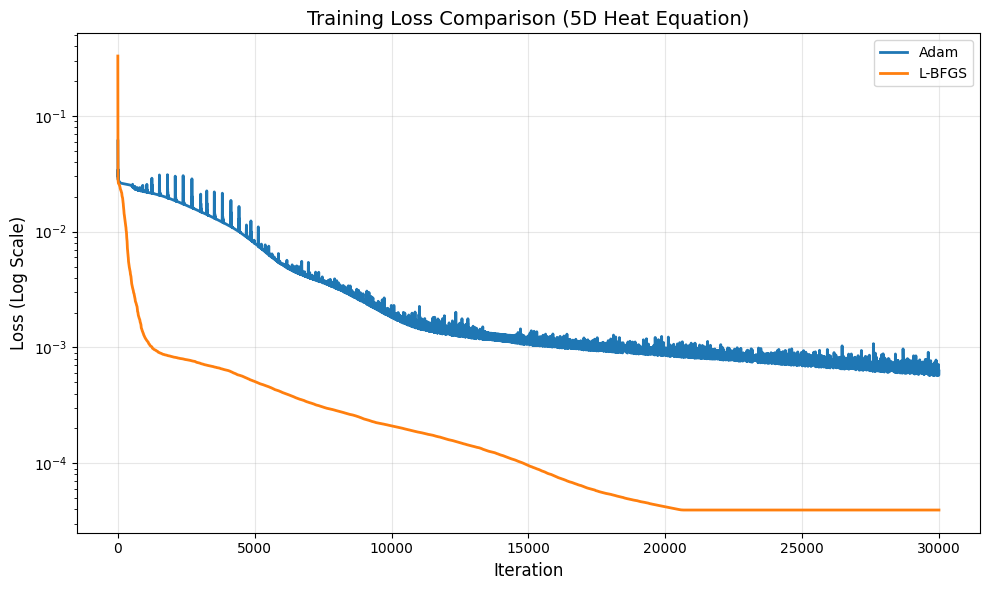


优化器训练时间对比
Adam       | 训练时间: 2679.75 秒 (44.66 分钟)
L-BFGS     | 训练时间: 9409.33 秒 (156.82 分钟)

最终L²误差对比
Adam    | L² 误差: 0.004560
L-BFGS  | L² 误差: 0.010170


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm
import matplotlib.pyplot as plt
import time

# 设置随机种子以保证结果可复现
torch.manual_seed(1224)
np.random.seed(1224)

# 1. 定义五维PINN模型
class PINN_5D(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(PINN_5D, self).__init__()
        # 输入层：5个空间变量 + 1个时间变量 = 6维输入
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        # 隐藏层
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        # 输出层
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)
    
    # 前向传播
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        input_tensor = torch.cat([x, t], dim=1)  # 拼接空间变量和时间变量
        for layer in self.layers:
            input_tensor = layer(input_tensor)
        return input_tensor

    # 计算偏导数：u_t（时间一阶偏导）和 Δu（五维拉普拉斯算子，即五个空间变量的二阶偏导之和）
    def compute_gradients(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        u = self.forward(x, t)  # 模型预测值
        
        # 计算 u_t：对时间 t 的一阶偏导
        u_t = torch.autograd.grad(
            outputs=u,
            inputs=t,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # 计算每个空间变量的二阶偏导，求和得到拉普拉斯算子Δu
        u_xx_sum = torch.zeros_like(u)
        for k in range(x.shape[1]):  # 遍历5个空间变量x1-x5
            # 一阶偏导
            u_xk = torch.autograd.grad(
                outputs=u,
                inputs=x,
                grad_outputs=torch.ones_like(u),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0][:, k:k+1]  # 取第k个维度的偏导
            
            # 二阶偏导
            u_xkxk = torch.autograd.grad(
                outputs=u_xk,
                inputs=x,
                grad_outputs=torch.ones_like(u_xk),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0][:, k:k+1]  # 取第k个维度的二阶偏导
            
            u_xx_sum += u_xkxk
        
        return u_t, u_xx_sum

    # PDE损失：五维热方程 u_t - Δu = 0
    def pde_loss(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        u_t, u_xx_sum = self.compute_gradients(x, t)
        pde_residual = u_t - u_xx_sum
        return torch.mean(pde_residual ** 2)
    
    # 初始条件损失：u(x1,...,x5, 0) = ∏_{k=1}^5 sin(πxk)
    def initial_loss(self, x: torch.Tensor, t0: torch.Tensor) -> torch.Tensor:
        u_pred = self.forward(x, t0)
        u_exact = torch.ones_like(u_pred)
        for k in range(x.shape[1]):  # 五个空间变量分别计算sin(πxk)后乘积
            u_exact *= torch.sin(np.pi * x[:, k:k+1])
        initial_residual = u_pred - u_exact
        return torch.mean(initial_residual ** 2)
    
    # 边界条件损失：对每个空间变量xk，u(0, x2,...,x5, t)=0 和 u(1, x2,...,x5, t)=0
    def boundary_loss(self, boundary_points: list) -> torch.Tensor:
        total_boundary_loss = 0.0
        for (x_bound, t_bound) in boundary_points:  # 遍历所有边界点
            u_pred = self.forward(x_bound, t_bound)
            total_boundary_loss += torch.mean(u_pred ** 2) # 边界条件残差
        return total_boundary_loss

# 2. 生成五维训练和测试数据
def generate_5d_data(
    n_pde: int = 2000,
    n_initial: int = 500,
    n_boundary_per_var: int = 100,  # 每个空间变量的边界点数量
    n_test: int = 20  # 测试时每个维度的采样数（总测试点为n_test^5，需适中）
) -> tuple:
    # PDE内部点：x1-x5 ∈ (0,1), t ∈ (0,1)
    x_pde = torch.rand(n_pde, 5, requires_grad=True)
    t_pde = torch.rand(n_pde, 1, requires_grad=True)
    pde_data = (x_pde, t_pde)
    
    # 初始条件点：t=0, x1-x5 ∈ (0,1)
    x_initial = torch.rand(n_initial, 5, requires_grad=True)
    t_initial = torch.zeros_like(x_initial[:, 0:1], requires_grad=True)  # t=0
    initial_data = (x_initial, t_initial)
    
    # 边界条件点：每个空间变量的x=0和x=1，t ∈ (0,1)
    boundary_points = []
    for k in range(5):
        # 边界 x_k = 0
        x0 = torch.rand(n_boundary_per_var, 5)  
        x0[:, k] = 0.0 # 设置第k个空间变量为0
        x0.requires_grad_()  # 原地开启梯度计算
        t0 = torch.rand(n_boundary_per_var, 1, requires_grad=True)
        boundary_points.append((x0, t0))

        # 边界 x_k = 1：同样先赋值再开启梯度
        x1 = torch.rand(n_boundary_per_var, 5)
        x1[:, k] = 1.0
        x1.requires_grad_()
        t1 = torch.rand(n_boundary_per_var, 1, requires_grad=True)
        boundary_points.append((x1, t1))
    boundary_data = boundary_points

    
    # 测试数据：蒙特卡洛随机采样（五维网格采样开销过大）
    n_test_total = n_test ** 5  # 总测试点数
    x_test = torch.rand(n_test_total, 5)
    t_test = torch.rand(n_test_total, 1)
    test_data = (x_test, t_test)
    
    return pde_data, initial_data, boundary_data, test_data

# 3. 训练函数（Adam）
def train_adam(
    model: PINN_5D,
    optimizer: optim.Optimizer,
    epochs: int,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: tuple,
    loss_history: list
) -> None:
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    
    model.train()
    for epoch in range(epochs):
        # 计算各部分损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(boundary_data)
        total_loss = pde_loss + initial_loss + boundary_loss
        
        # 反向传播与参数更新
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        loss_history.append(total_loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(
                f'轮数 {epoch+1:4d} | 总损失: {total_loss.item():.6f} | '
                f'PDE损失: {pde_loss.item():.6f} | 初始损失: {initial_loss.item():.6f} | '
                f'边界损失: {boundary_loss.item():.6f}'
            )

# 4. 训练函数（L-BFGS）
def train_lbfgs(
    model: PINN_5D,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: tuple,
    loss_history: list,
    max_iter: int
) -> None:
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    
    model.train()

    # 用于保存最新分量损失值
    pde_loss_val = initial_loss_val = boundary_loss_val = 0.0
    
    def closure() -> torch.Tensor:
        nonlocal pde_loss_val, initial_loss_val, boundary_loss_val # 声明非局部变量
        optimizer.zero_grad()
        # 计算损失
        pde_loss = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(boundary_data)
        total_loss = pde_loss + initial_loss + boundary_loss
        # 反向传播
        total_loss.backward()

        # 保存当前分量值
        pde_loss_val = pde_loss.item()
        initial_loss_val = initial_loss.item()
        boundary_loss_val = boundary_loss.item()

        return total_loss
    
    # 初始化L-BFGS优化器
    optimizer = optim.LBFGS(
        model.parameters(),
        max_iter= 1,  # 最大迭代次数
        max_eval= 10,  # 最大函数评估次数
        line_search_fn='strong_wolfe',  # 线搜索策略
        lr=1.0  # L-BFGS的学习率通常设为1.0
    )
    
    # 开始训练
    for iter_idx in range(max_iter):
        # 执行一次L-BFGS迭代
        total_loss = optimizer.step(closure)
        # 获取当前损失值
        current_loss = total_loss.item()
        # 记录当前损失
        loss_history.append(current_loss)
        # 打印迭代信息
        if (iter_idx + 1) % 500 == 0 or iter_idx == 0:
            print(
                f'迭代 {iter_idx+1}/{max_iter} | 总损失: {current_loss:.6f} | '
                f'PDE损失: {pde_loss_val:.6f} | 初始条件损失: {initial_loss_val:.6f} | '
                f'边界条件损失: {boundary_loss_val:.6f}'
            )

# 5. 评估函数（L²误差）
def evaluate_5d(
    model: PINN_5D,
    test_data: tuple,
    lambda_val: float
) -> float:
    x_test, t_test = test_data
    model.eval()
    with torch.no_grad():
        u_pred = model(x_test, t_test)
        # 计算精确解：u_exact = e^(-λ t) * ∏_{k=1}^5 sin(π xk)，其中λ=5π²
        u_exact = torch.exp(-lambda_val * t_test)
        for k in range(5):
            u_exact *= torch.sin(np.pi * x_test[:, k:k+1])
        # 计算L²误差
        l2_error = torch.sqrt(torch.mean((u_pred - u_exact) ** 2)).item()
    return l2_error

# 6. 绘制损失曲线
def plot_loss_curve(loss_histories: list, labels: list) -> None:
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.title('Training Loss Comparison (5D Heat Equation)', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 7. 主函数
def train_5D_heat_PINN():
    # 超参数
    n_layers = 4               # 输入层和隐藏层数量
    input_dim = 6              # 5个空间变量 + 1个时间变量
    output_dim = 1             # 输出维度（u）
    hidden_dim = 30            # 五维问题需增加隐藏层神经元数以提升表达能力
    n_pde = 2000               # 五维PDE点数量需增加
    n_initial = 500            # 初始条件点数量
    n_boundary_per_var = 200   # 每个空间变量的边界点数量
    epochs_adam = 30000        # Adam训练轮数
    max_iter_lbfgs = 30000     # L-BFGS迭代次数
    lambda_val = 5 * np.pi**2  # 五维时λ=5π²
    
    # 生成数据
    pde_data, initial_data, boundary_data, test_data = generate_5d_data(
        n_pde=n_pde,
        n_initial=n_initial,
        n_boundary_per_var=n_boundary_per_var,
        n_test=5  # 测试时每个维度采样5个点，总测试点5^5=3125
    )
    
    training_times = [] # 存储训练时间

    # 训练Adam
    print("\n" + "="*50)
    print("使用Adam训练")
    print("="*50)
    model_adam = PINN_5D(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
    loss_history_adam = []
    start_time_adam = time.time() # 记录开始时间
    train_adam(
        model=model_adam,
        optimizer=optimizer_adam,
        epochs=epochs_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam
    )
    end_time_adam = time.time() # 记录结束时间
    training_time_adam = end_time_adam - start_time_adam # 计算训练时间
    training_times.append(training_time_adam)
    print(f"Adam训练时间: {training_time_adam:.2f} 秒({training_time_adam/60:.2f} 分钟)")

    l2_error_adam = evaluate_5d(model_adam, test_data, lambda_val)
    print(f"Adam L² 误差: {l2_error_adam:.6f}")
    
    # 训练L-BFGS
    print("\n" + "="*50)
    print("使用L-BFGS训练")
    print("="*50)
    model_lbfgs = PINN_5D(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_lbfgs = []
    start_time_lbfgs = time.time() # 记录开始时间
    train_lbfgs(
        model=model_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_lbfgs,
        max_iter=max_iter_lbfgs
    )
    end_time_lbfgs = time.time() # 记录结束时间
    training_time_lbfgs = end_time_lbfgs - start_time_lbfgs # 计算训练时间
    training_times.append(training_time_lbfgs)
    print(f"L-BFGS训练时间: {training_time_lbfgs:.2f} 秒({training_time_lbfgs/60:.2f} 分钟)")

    l2_error_lbfgs = evaluate_5d(model_lbfgs, test_data, lambda_val)
    print(f"L-BFGS L² 误差: {l2_error_lbfgs:.6f}")
    
    # 绘制损失曲线
    plot_loss_curve([loss_history_adam, loss_history_lbfgs], ['Adam', 'L-BFGS'])
    
    # 打印训练时间对比
    print("\n" + "="*50)
    print("优化器训练时间对比")
    print("="*50)
    optimizers = ['Adam', 'L-BFGS']
    for opt, time_sec in zip(optimizers, training_times):
        print(f"{opt:<10} | 训练时间: {time_sec:.2f} 秒 ({time_sec/60:.2f} 分钟)")

    # 打印最终误差对比
    print("\n" + "="*50)
    print("最终L²误差对比")
    print("="*50)
    print(f"Adam    | L² 误差: {l2_error_adam:.6f}")
    print(f"L-BFGS  | L² 误差: {l2_error_lbfgs:.6f}")

# 执行主函数
train_5D_heat_PINN()